In [80]:
import re
import gc
import numpy as np
import pandas as pd
from keras import Sequential, Model
from keras.layers import LSTM, Dense, Input, Concatenate, Bidirectional

In [5]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [6]:
!wget 'https://nlp.stanford.edu/data/glove.6B.zip'
!unzip -q glove.6B.zip

glove = {}
file =  open('glove.6B.300d.txt', 'r')
for line in file:
  values = line.split()
  word = values[0]
  emb = np.asarray(values[1:])
  glove[word] = emb
file.close()

--2023-05-24 11:03:15--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-24 11:03:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 38s  

2023-05-24 11:05:54 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [10]:
def make_data_coarse(df):
  x = []
  y = []
  for i in range(len(df)):
    next = False
    text = df.iloc[i]['text'].lower()
    words = re.sub(r'[^\w^\s^?]', '', text).split()
    embs = np.zeros((35, 300))
    for j in range(len(words)):
      if words[j] in glove:
        embs[j, :] = glove[words[j]]
      else:
        next = True
        break
    if next:
      continue
    y.append(np.eye(6)[:, df.iloc[i]['label-coarse']])
    x.append(embs)
    
  return np.array(x), np.array(y)

x_train, y_train = make_data_coarse(data_train)
x_test, y_test = make_data_coarse(data_test)
freed_ram = gc.collect()

In [16]:
model_25 = Sequential([
    LSTM(25, input_shape=(35, 300), name='lstm25_coarse'),
    Dense(6, activation='softmax', name='dense25_coarse')
])
model_25.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_25.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm25_coarse (LSTM)        (None, 25)                32600     
                                                                 
 dense25_coarse (Dense)      (None, 6)                 156       
                                                                 
Total params: 32,756
Trainable params: 32,756
Non-trainable params: 0
_________________________________________________________________


In [17]:
history25 = model_25.fit(x_train, y_train, batch_size=30, epochs=50, validation_data=(x_test, y_test))


Epoch 1/50
167/167 [==============================] - 10s 28ms/step - loss: 1.6489 - accuracy: 0.2614 - val_loss: 1.4696 - val_accuracy: 0.3996
Epoch 2/50
167/167 [==============================] - 7s 41ms/step - loss: 1.3240 - accuracy: 0.4432 - val_loss: 1.0961 - val_accuracy: 0.6410
Epoch 3/50
167/167 [==============================] - 8s 49ms/step - loss: 0.9562 - accuracy: 0.6627 - val_loss: 0.6539 - val_accuracy: 0.8053
Epoch 4/50
167/167 [==============================] - 5s 32ms/step - loss: 0.6914 - accuracy: 0.7720 - val_loss: 0.6544 - val_accuracy: 0.8073
Epoch 5/50
167/167 [==============================] - 4s 24ms/step - loss: 0.5879 - accuracy: 0.8133 - val_loss: 0.4643 - val_accuracy: 0.8641
Epoch 6/50
167/167 [==============================] - 4s 24ms/step - loss: 0.5306 - accuracy: 0.8309 - val_loss: 0.4378 - val_accuracy: 0.8682
Epoch 7/50
167/167 [==============================] - 5s 30ms/step - loss: 0.4593 - accuracy: 0.8559 - val_loss: 0.4170 - val_accuracy: 0.868

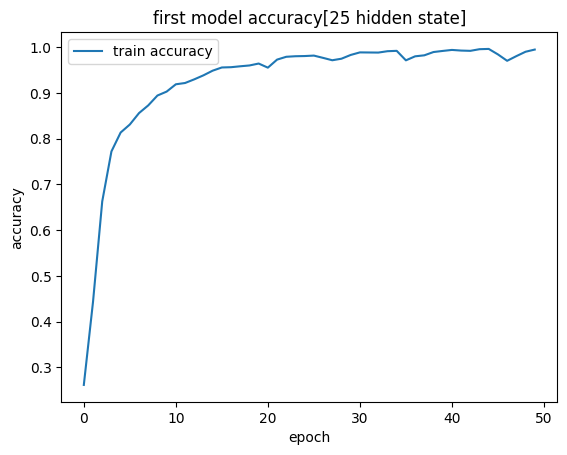

In [19]:
#accuracy
import matplotlib.pyplot as plt
plt.plot(history25.history['accuracy'])
plt.title('first model accuracy[25 hidden state]')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy'], loc='upper left')
plt.show()

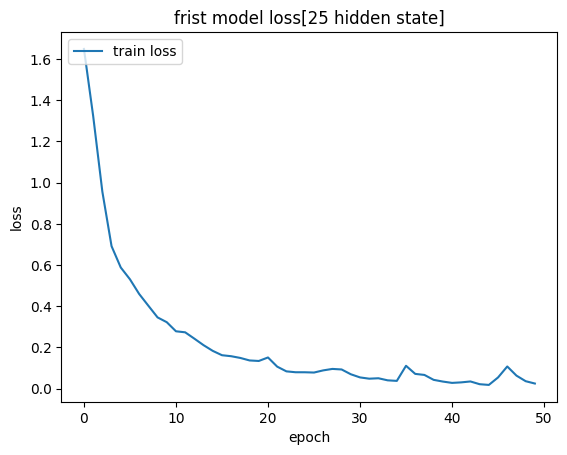

In [20]:
#loss
plt.plot(history25.history['loss'])
plt.title('frist model loss[25 hidden state]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [63]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_25.predict(x_test),axis=1)
accuracy_score(np.argmax(y_test, axis=1), y_pred)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

16/16 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

     class 0       0.83      0.96      0.89       136
     class 1       0.89      0.75      0.81        93
     class 2       0.62      0.89      0.73         9
     class 3       0.95      0.91      0.93        64
     class 4       0.99      0.88      0.93       113
     class 5       0.83      0.87      0.85        78

    accuracy                           0.88       493
   macro avg       0.85      0.88      0.86       493
weighted avg       0.89      0.88      0.88       493

[[130   2   4   0   0   0]
 [ 11  70   1   2   1   8]
 [  1   0   8   0   0   0]
 [  1   3   0  58   0   2]
 [  8   1   0   0 100   4]
 [  6   3   0   1   0  68]]


In [64]:
model_100 = Sequential([
    LSTM(100, input_shape=(35, 300), name='lstm100_coarse'),
    Dense(6, activation='softmax', name='dense100_coarse')
])
model_100.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_100.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm100_coarse (LSTM)       (None, 100)               160400    
                                                                 
 dense100_coarse (Dense)     (None, 6)                 606       
                                                                 
Total params: 161,006
Trainable params: 161,006
Non-trainable params: 0
_________________________________________________________________


In [65]:
history100 = model_100.fit(x_train, y_train, batch_size=30, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
167/167 [==============================] - 15s 73ms/step - loss: 1.4565 - accuracy: 0.3737 - val_loss: 1.1258 - val_accuracy: 0.5639
Epoch 2/50
167/167 [==============================] - 9s 56ms/step - loss: 0.9462 - accuracy: 0.6645 - val_loss: 0.7156 - val_accuracy: 0.7748
Epoch 3/50
167/167 [==============================] - 11s 64ms/step - loss: 0.6882 - accuracy: 0.7700 - val_loss: 0.4904 - val_accuracy: 0.8560
Epoch 4/50
167/167 [==============================] - 11s 66ms/step - loss: 0.5557 - accuracy: 0.8147 - val_loss: 0.4969 - val_accuracy: 0.8276
Epoch 5/50
167/167 [==============================] - 12s 72ms/step - loss: 0.4799 - accuracy: 0.8363 - val_loss: 0.4512 - val_accuracy: 0.8519
Epoch 6/50
167/167 [==============================] - 11s 66ms/step - loss: 0.4174 - accuracy: 0.8599 - val_loss: 0.3353 - val_accuracy: 0.8966
Epoch 7/50
167/167 [==============================] - 10s 59ms/step - loss: 0.4568 - accuracy: 0.8489 - val_loss: 0.4438 - val_accuracy: 

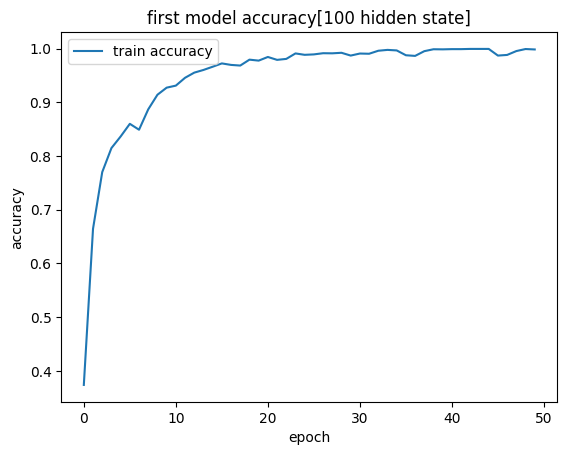

In [67]:
#accuracy
import matplotlib.pyplot as plt
plt.plot(history100.history['accuracy'])
plt.title('first model accuracy[100 hidden state]')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy'], loc='upper left')
plt.show()

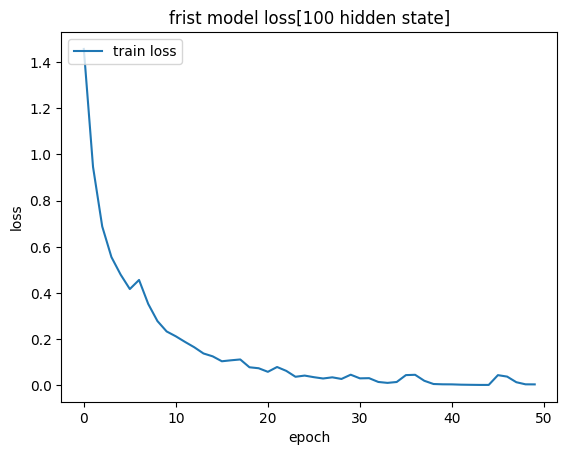

In [68]:
#loss
plt.plot(history100.history['loss'])
plt.title('frist model loss[100 hidden state]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_100.predict(x_test),axis=1)
accuracy_score(np.argmax(y_test, axis=1), y_pred)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

16/16 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

     class 0       0.84      0.96      0.89       136
     class 1       0.85      0.80      0.82        93
     class 2       0.88      0.78      0.82         9
     class 3       0.94      0.92      0.93        64
     class 4       1.00      0.91      0.95       113
     class 5       0.90      0.88      0.89        78

    accuracy                           0.90       493
   macro avg       0.90      0.87      0.89       493
weighted avg       0.90      0.90      0.90       493

[[130   5   1   0   0   0]
 [ 11  74   0   3   0   5]
 [  1   1   7   0   0   0]
 [  1   2   0  59   0   2]
 [  7   2   0   0 103   1]
 [  5   3   0   1   0  69]]


In [71]:
def make_data_fine(df):
  y = []
  for i in range(len(df)):
    next = False
    text = df.iloc[i]['text'].lower()
    words = re.sub(r'[^\w^\s^?]', '', text).split()
    for j in range(len(words)):
      if words[j] not in glove:
        next = True
        break
    if next:
      continue
    y.append(np.eye(47)[:, df.iloc[i]['label-fine']])
    
  return np.array(y)

y_train_fine = make_data_fine(data_train)
y_test_fine = make_data_fine(data_test)

In [72]:
input25 = Input(shape=(36, 300), name='input25')
lstm25_fine = LSTM(25, return_sequences=True, name='lstm25_fine')(input25)
coarse25 = Dense(6, activation='softmax', name='dense25_coarse')(lstm25_fine[:, -2, :])
fine25 = Dense(47, activation='softmax', name='dense25_fine')(lstm25_fine[:, -1, :])
model25_fine = Model(inputs=input25, outputs=[coarse25, fine25])
model25_fine.summary()
model25_fine.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input25 (InputLayer)           [(None, 36, 300)]    0           []                               
                                                                                                  
 lstm25_fine (LSTM)             (None, 36, 25)       32600       ['input25[0][0]']                
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 25)          0           ['lstm25_fine[0][0]']            
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 25)          0           ['lstm25_fine[0][0]']      

In [73]:
history25_sub = model25_fine.fit(np.concatenate([x_train, np.zeros((len(x_train), 1, 300))], 1), 
                                 [y_train, y_train_fine], batch_size=30, epochs=50, 
                                 validation_data=(np.concatenate([x_test, np.zeros((len(x_test), 1, 300))], 1), 
                                                  [y_test, y_test_fine]))

Epoch 1/50
167/167 [==============================] - 8s 30ms/step - loss: 4.9627 - dense25_coarse_loss: 1.6826 - dense25_fine_loss: 3.2801 - dense25_coarse_accuracy: 0.2338 - dense25_fine_accuracy: 0.1625 - val_loss: 4.8591 - val_dense25_coarse_loss: 1.6628 - val_dense25_fine_loss: 3.1964 - val_dense25_coarse_accuracy: 0.3489 - val_dense25_fine_accuracy: 0.1095
Epoch 2/50
167/167 [==============================] - 5s 32ms/step - loss: 4.3256 - dense25_coarse_loss: 1.4514 - dense25_fine_loss: 2.8742 - dense25_coarse_accuracy: 0.4131 - dense25_fine_accuracy: 0.2716 - val_loss: 4.0880 - val_dense25_coarse_loss: 1.2985 - val_dense25_fine_loss: 2.7895 - val_dense25_coarse_accuracy: 0.4706 - val_dense25_fine_accuracy: 0.4787
Epoch 3/50
167/167 [==============================] - 7s 39ms/step - loss: 3.9174 - dense25_coarse_loss: 1.2479 - dense25_fine_loss: 2.6695 - dense25_coarse_accuracy: 0.5180 - dense25_fine_accuracy: 0.3269 - val_loss: 3.7514 - val_dense25_coarse_loss: 1.1566 - val_dense

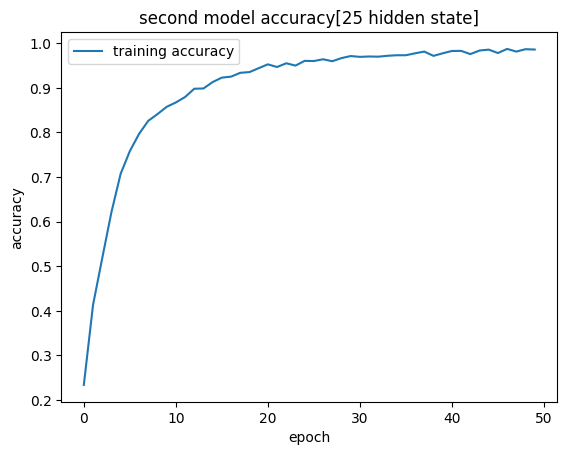

In [87]:
#accuracy
# history25_sub.history
b= history25_sub.history['dense25_coarse_accuracy']
import matplotlib.pyplot as plt
plt.plot(b)
plt.title('second model accuracy[25 hidden state]')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy'], loc='upper left')
plt.show()

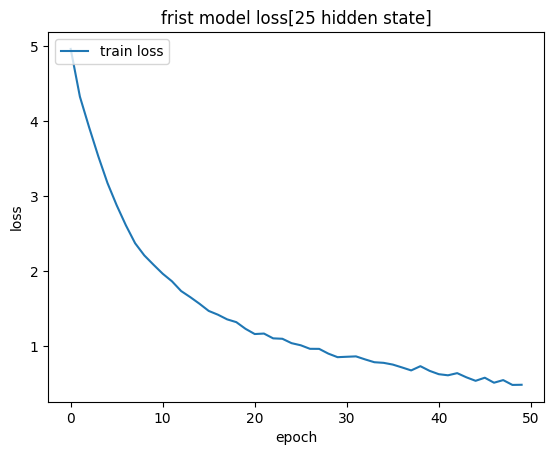

In [88]:
#loss
plt.plot(history25_sub.history['loss'])
plt.title('frist model loss[25 hidden state]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_100.predict(x_test),axis=1)
accuracy_score(np.argmax(y_test, axis=1), y_pred)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

16/16 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

     class 0       0.84      0.96      0.89       136
     class 1       0.85      0.80      0.82        93
     class 2       0.88      0.78      0.82         9
     class 3       0.94      0.92      0.93        64
     class 4       1.00      0.91      0.95       113
     class 5       0.90      0.88      0.89        78

    accuracy                           0.90       493
   macro avg       0.90      0.87      0.89       493
weighted avg       0.90      0.90      0.90       493

[[130   5   1   0   0   0]
 [ 11  74   0   3   0   5]
 [  1   1   7   0   0   0]
 [  1   2   0  59   0   2]
 [  7   2   0   0 103   1]
 [  5   3   0   1   0  69]]


In [90]:
input100 = Input(shape=(36, 300), name='input100')
lstm100_fine = LSTM(100, return_sequences=True, name='lstm100_fine')(input100)
coarse100 = Dense(6, activation='softmax', name='dense100_coarse')(lstm100_fine[:, -2, :])
fine100 = Dense(47, activation='softmax', name='dense100_fine')(lstm100_fine[:, -1, :])
model100_fine = Model(inputs=input100, outputs=[coarse100, fine100])
model100_fine.summary()
model100_fine.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input100 (InputLayer)          [(None, 36, 300)]    0           []                               
                                                                                                  
 lstm100_fine (LSTM)            (None, 36, 100)      160400      ['input100[0][0]']               
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 100)         0           ['lstm100_fine[0][0]']           
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 100)         0           ['lstm100_fine[0][0]']     

In [91]:
history100_sub = model100_fine.fit(np.concatenate([x_train, np.zeros((len(x_train), 1, 300))], 1), 
                                 [y_train, y_train_fine], batch_size=30, epochs=50, 
                                 validation_data=(np.concatenate([x_test, np.zeros((len(x_test), 1, 300))], 1), 
                                                  [y_test, y_test_fine]))

Epoch 1/50
167/167 [==============================] - 15s 73ms/step - loss: 4.8366 - dense100_coarse_loss: 1.6755 - dense100_fine_loss: 3.1610 - dense100_coarse_accuracy: 0.2098 - dense100_fine_accuracy: 0.1661 - val_loss: 4.9453 - val_dense100_coarse_loss: 1.6710 - val_dense100_fine_loss: 3.2744 - val_dense100_coarse_accuracy: 0.1866 - val_dense100_fine_accuracy: 0.1440
Epoch 2/50
167/167 [==============================] - 11s 67ms/step - loss: 4.0845 - dense100_coarse_loss: 1.3448 - dense100_fine_loss: 2.7396 - dense100_coarse_accuracy: 0.4388 - dense100_fine_accuracy: 0.2808 - val_loss: 3.7244 - val_dense100_coarse_loss: 1.1268 - val_dense100_fine_loss: 2.5976 - val_dense100_coarse_accuracy: 0.5680 - val_dense100_fine_accuracy: 0.4665
Epoch 3/50
167/167 [==============================] - 10s 61ms/step - loss: 3.0750 - dense100_coarse_loss: 0.8717 - dense100_fine_loss: 2.2034 - dense100_coarse_accuracy: 0.6689 - dense100_fine_accuracy: 0.4225 - val_loss: 2.7927 - val_dense100_coarse_

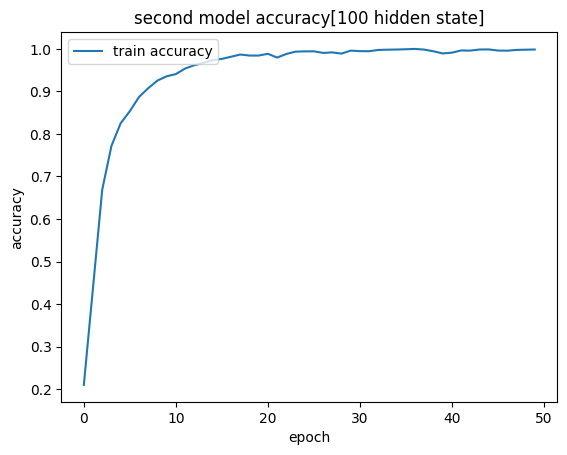

In [93]:
#accuracy
import matplotlib.pyplot as plt
plt.plot(history100_sub.history['dense100_coarse_accuracy'])
plt.title('second model accuracy[100 hidden state]')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy'], loc='upper left')
plt.show()

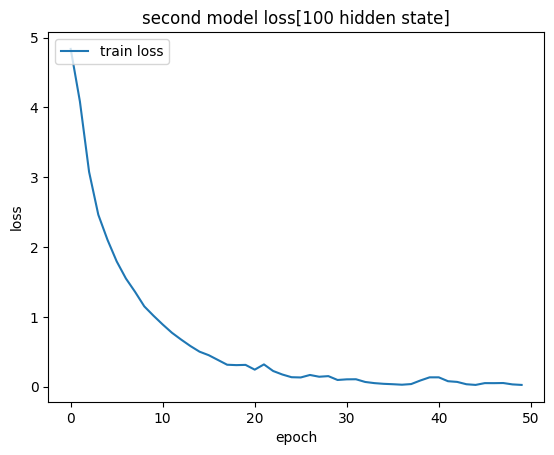

In [94]:
#loss
plt.plot(history100_sub.history['loss'])
plt.title('second model loss[100 hidden state]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [95]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_100.predict(x_test),axis=1)
accuracy_score(np.argmax(y_test, axis=1), y_pred)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

16/16 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

     class 0       0.84      0.96      0.89       136
     class 1       0.85      0.80      0.82        93
     class 2       0.88      0.78      0.82         9
     class 3       0.94      0.92      0.93        64
     class 4       1.00      0.91      0.95       113
     class 5       0.90      0.88      0.89        78

    accuracy                           0.90       493
   macro avg       0.90      0.87      0.89       493
weighted avg       0.90      0.90      0.90       493

[[130   5   1   0   0   0]
 [ 11  74   0   3   0   5]
 [  1   1   7   0   0   0]
 [  1   2   0  59   0   2]
 [  7   2   0   0 103   1]
 [  5   3   0   1   0  69]]


part 2


In [96]:
data_responder = pd.read_csv('QA_data.csv', encoding = "ISO-8859-1")
words = []
for i in range(len(data_responder)):
  answer = data_responder.iloc[i]['answer'].lower()
  answer_words = re.sub(r'[^\w^\s^?]', '', answer).split()
  for word in answer_words:
    if word not in words:
      words.append(word)

In [97]:
def make_data_responder(df):
  x = []
  y = []
  for i in range(len(df)):
    next = False
    question = df.iloc[i]['text'].lower()
    question_words = re.sub(r'[^\w^\s^?]', '', question).split()
    question_embs = np.zeros((36, 300))
    answer = df.iloc[i]['answer'].lower()
    answer_words = re.sub(r'[^\w^\s^?]', '', answer).split()
    for j in range(len(question_words)):
      if question_words[j] in glove:
        question_embs[j, :] = glove[question_words[j]]
      else:
        next = True
        break
    answer_onehot = np.zeros((35, len(words)))
    for j in range(len(answer_words)):
      answer_onehot[j] = np.eye(len(words))[:, words.index(answer_words[j])]
    if next:
      continue
    y.append(answer_onehot)
    x.append(question_embs)
    
  return np.array(x), np.array(y)

x_responder, y_responder = make_data_responder(data_responder)
freed_ram = gc.collect()

In [98]:
initial_states = [Concatenate()([lstm100_fine[:, -1, :], lstm100_fine[:, -2, :]])] * 4
bidirectional = Bidirectional(LSTM(200, return_sequences=True), name='blstm_responder')(input100[:, :-1, :], initial_state=initial_states)
dense = Dense(len(words), activation='softmax', name='dense_responder')(bidirectional)

model_responder = Model(inputs = input100, outputs = dense)
model_responder.layers[1].trainable = False;
model_responder.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_responder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input100 (InputLayer)          [(None, 36, 300)]    0           []                               
                                                                                                  
 lstm100_fine (LSTM)            (None, 36, 100)      160400      ['input100[0][0]']               
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 100)         0           ['lstm100_fine[0][0]']           
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_7 (Sl  (None, 100)         0           ['lstm100_fine[0][0]']     

In [99]:
history_responder = model_responder.fit(x_responder, y_responder, batch_size=30, epochs=1000)

Epoch 1/1000
17/17 [==============================] - 11s 247ms/step - loss: 0.3991 - accuracy: 0.0070
Epoch 2/1000
17/17 [==============================] - 4s 235ms/step - loss: 0.3937 - accuracy: 0.0014
Epoch 3/1000
17/17 [==============================] - 5s 326ms/step - loss: 0.3895 - accuracy: 0.0014
Epoch 4/1000
17/17 [==============================] - 4s 237ms/step - loss: 0.3891 - accuracy: 0.0014
Epoch 5/1000
17/17 [==============================] - 5s 289ms/step - loss: 0.3885 - accuracy: 0.0014
Epoch 6/1000
17/17 [==============================] - 6s 363ms/step - loss: 0.3879 - accuracy: 0.0014
Epoch 7/1000
17/17 [==============================] - 4s 238ms/step - loss: 0.3878 - accuracy: 0.0014
Epoch 8/1000
17/17 [==============================] - 4s 238ms/step - loss: 0.3871 - accuracy: 0.0014
Epoch 9/1000
17/17 [==============================] - 5s 314ms/step - loss: 0.3871 - accuracy: 0.0014
Epoch 10/1000
17/17 [==============================] - 4s 242ms/step - loss: 0.38

In [103]:
def find_answer(question):
  question = question.lower()
  question_words = re.sub(r'[^\w^\s^?]', '', question).split()
  question_embs = np.zeros((1, 36, 300))
  index = 0
  for question_word in question_words:
    if question_word not in glove:
      return None
    else:
      question_embs[:, index, :] = glove[question_word]
      index += 1
  answer_onehots = model_responder(question_embs)
  answer = ''
  for answer_onehot in answer_onehots[0]:
    answer += words[np.argmax(answer_onehot)] + ' '
  return answer.split()[0]

print(find_answer('How many people speak French ?'))
print(find_answer('What day is today ?'))
print(find_answer('Who will win the war ?'))
print(find_answer('Who is Italian first minister ?'))
print(find_answer('When World War II ended ?'))
print(find_answer('When Gandhi was assassinated ?'))

3
1907
edwin
edwin
21jun
1773
